# Lab 4 - Kernel Regularized Least Squares

In this lab activity we consider the extension of regularized least squares to non-linear problems using kernel functions.

A brief summary of the tasks:
 1. Generate a simple non-linear data-set
 2. Use **linear** RLS to try and learn with such dataset
 3. Use a **feature transformation** for learning with non-linear data
 4. Implement various kernel functions
 5. Implement kernel RLS
 6. Generate a more complex non-linear data-set
 7. Use kernel RLS for learning on non-linear data, use cross-validation to find the best hyperparameters.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import os

In [10]:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

# Part 1: Learning with a simple non-linear dataset

## Generate quadratic data

In this lab we are going to use regression datasets where the target `Y` is **not a linear function** of the inputs `X`.

As a first example, see the following function to generate quadratic data.

In [11]:
def quadratic_data_gen(n, w, sigma_noise):
    X = np.random.uniform(-3, 3, size=(n, 1))
    Xsq = X ** 2
    noise = np.random.normal(0, sigma_noise, size=(n, 1))

    # Here we can use scalar multiplication since in dimension 1
    Y = Xsq * w + noise
    
    return X, Y

Shape of x: (100, 1), shape of y: (100, 1)


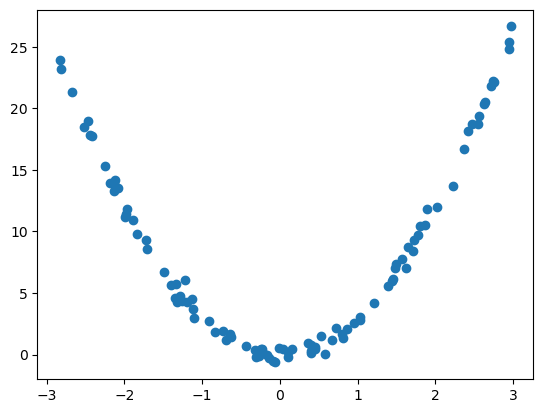

In [12]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

print(f"Shape of x: {x_tr.shape}, shape of y: {y_tr.shape}")
fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr);

## Task 1: Linear RLS

The implementation of linear regularized least-squares is given below in the functions `rls_train` and `rls_predict`. 

Remember: regularized least-squares has the following form

$$(X_{tr}^\top X_{tr} + \lambda n I)w = X_{tr}^\top Y_{tr}$$


Tasks:
 - Use RLS to train a linear regressor for the quadratic data. Comment on the results.

def rls_train(x, y, reg_par):
    # y = wx + b
    # reg_par = \( \lambda \) is the regularization parameter to regulize
        # fitting.
    # @ means dot production between two matrix, here x.T and x 
        # x.T is x transpose
    # The left side of the equation = X_{tr}^\top X_{tr} + \lambda n I
    # x.shape[0] = n -> The number of samples ([0] = rows)
    ''' 
    >>> np.eye(2)
                array([[1., 0.],
                       [0., 1.]])
    >>> np.eye(3)
                array([[1., 0., 0.],
                       [0., 1., 0.],
                       [0., 0., 1.]]) 
    '''
    cov = x.T @ x + reg_par * x.shape[0] * np.eye(x.shape[1])
		# The right side of the equation = X_{tr}^\top Y_{tr}
    rhs = x.T @ y
		# (cov)(w) = rhs by having the cov and rhs, the variable to solve is w
			# np.linalg.solve helps to solve this mathematical question
    w = np.linalg.solve(cov, rhs)
    return w

In [18]:
def rls_predict(x, w):
    return x @ w

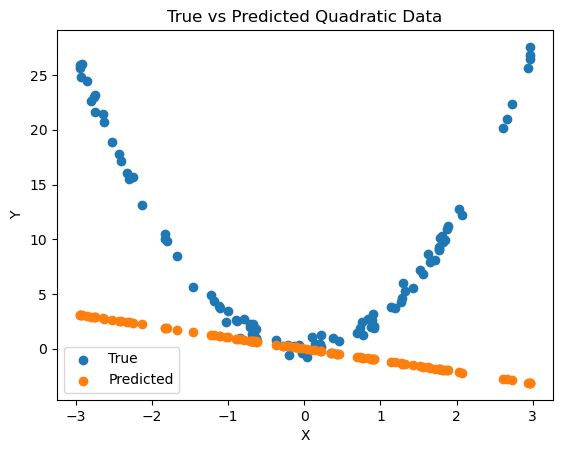

In [19]:
import matplotlib.pyplot as plt
import numpy as np

"""
The Roadmap:
	- Random Data Generation
	- Regularization Parameter Setting 
	- Weight Vector Calculation
	- Predicted Y Calculation Based on X_train and Weight Vector
	- Visualization
"""

# Generate quadratic data
# quadratic_data_gen(n, w, sigma_noise)
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# Assuming you have the weights (w) and want to predict based on the quadratic model
# Replace ... with the correct computation based on the weights
# w = ...
# My code
reg_par = 0.01
w = rls_train(x_tr, y_tr, reg_par)

# Predict using the quadratic model
# Assuming x_tr is a vector of input features
# Replace ... with the correct computation based on the quadratic model
# pred_tr = ...
# My code
pred_tr = rls_predict(x_tr, w)

# Visualize the true and predicted data
fig, ax = plt.subplots()
# x_tr = x, y_tr = y
ax.scatter(x_tr, y_tr, label="True")
# # x_tr = x, pred_tr = y
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("True vs Predicted Quadratic Data")
plt.show()

## Task 2: Feature transform

There is a simple way to use a linear algorithm for learning non-linear data: transforming the input data in such a way to convert the problem into a linear one.

This is a simple fix in some cases, but becomes cumbersome if the datasets are non-linear in a complex way.

Here we adopt this approach to train a RLS classifier with the quadratic dataset:
 1. Generate the quadratic dataset
 2. Transform the data so that it becomes a (n, 2) matrix containing the original input, and a transformed version of itself. Clearly the correct transformation depends on the underlying function (a quadratic function!).
 3. Use the RLS algorithm on the new dataset
 4. Plot **and comment** on the results

In [20]:
import numpy as np

# Generate quadratic data
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# Transformation: Build a feature matrix with the original features and their squares
# Create a new column with the squares of the original features
squared_x_tr = np.square(x_tr)
print("x_tr: {0}".format(x_tr))
print("squared_x_tr: {0}".format(squared_x_tr))

# Concatenate the original features and the squared features along the columns (axis=1)
# The sqaures of the original features column of x_tr (new column)
	# is combined with the original x_tr; however, before concatenation
	# they are reshaped into just one column
trsf_x_tr = np.concatenate([x_tr.reshape(-1, 1), squared_x_tr.reshape(-1, 1)], axis=1)
print("trsf_x_tr: {0}".format(trsf_x_tr))

# Assertion to check the shape of the transformed feature matrix
# The condition expression is = assert trsf_x_tr.shape == (x_tr.shape[0], 2)
		# The error message, if the condition is false is: f"Shape of x_tr is {x_tr.shape}. Expected ({x_tr.shape[0]}, 2)"
				# f string is used when expression in the string is utilized 	
#  trsf_x_tr should have the same number of rows as x_tr and 2 columns
assert trsf_x_tr.shape == (x_tr.shape[0], 2), f"Shape of x_tr is {x_tr.shape}. Expected ({x_tr.shape[0]}, 2)"
# Print tage, if the condition is false is: f\"Shape of x_the transformed feature matrix"
print("Transformed Feature Matrix:")
print(trsf_x_tr)

x_tr: [[ 2.94416726]
 [-2.33881396]
 [ 1.97890354]
 [-0.14149683]
 [-0.57054342]
 [-2.28395721]
 [-0.82786034]
 [ 1.52771836]
 [ 2.50437873]
 [ 1.36630333]
 [ 1.92196115]
 [ 1.80329925]
 [ 2.25263806]
 [ 2.12318198]
 [ 2.96422134]
 [ 0.34369885]
 [-0.95441373]
 [ 0.13199986]
 [ 2.70374226]
 [-1.05399559]
 [-0.82737229]
 [ 1.02872851]
 [-2.89995588]
 [ 2.07952045]
 [ 1.98557984]
 [-1.02272614]
 [ 1.15815489]
 [ 2.55982511]
 [ 2.1323291 ]
 [ 1.31280183]
 [ 2.55014968]
 [-1.22555413]
 [ 0.86638603]
 [ 2.69415332]
 [-2.674639  ]
 [-2.36616655]
 [-1.68479346]
 [ 1.94913499]
 [-2.06386558]
 [-0.49542985]
 [ 0.66164269]
 [-2.79329459]
 [ 1.42117797]
 [-1.65993597]
 [ 2.12354349]
 [-2.73665557]
 [ 0.4056702 ]
 [ 0.66289452]
 [ 1.24990171]
 [-0.11487623]
 [ 0.90662183]
 [ 0.91257103]
 [-2.28272901]
 [ 1.73662832]
 [ 0.91503714]
 [ 0.39568675]
 [ 2.19114981]
 [ 0.48796463]
 [-2.14585813]
 [ 0.32567581]
 [-1.25083526]
 [-1.81598042]
 [ 0.35806012]
 [-2.59046389]
 [-1.26755584]
 [-2.27291147]
 [ 2

trsf_w_rls: [[0.00908692]
 [2.99172924]]
pred_tr: [[2.59594240e+01]
 [1.63436581e+01]
 [1.17337710e+01]
 [5.86126996e-02]
 [9.68682608e-01]
 [1.55854833e+01]
 [2.04286712e+00]
 [6.99634908e+00]
 [1.87866220e+01]
 [5.59733014e+00]
 [1.10687170e+01]
 [9.74515541e+00]
 [1.52016353e+01]
 [1.35057146e+01]
 [2.63140882e+01]
 [3.56532856e-01]
 [2.71651012e+00]
 [5.33272538e-02]
 [2.18947742e+01]
 [3.31395447e+00]
 [2.04045473e+00]
 [3.17544224e+00]
 [2.51333257e+01]
 [1.29563462e+01]
 [1.18130170e+01]
 [3.11996189e+00]
 [4.02339853e+00]
 [1.96271789e+01]
 [1.36222527e+01]
 [5.16802104e+00]
 [1.94791763e+01]
 [4.48238972e+00]
 [2.25353882e+00]
 [2.17398349e+01]
 [2.13776107e+01]
 [1.67284254e+01]
 [8.47680062e+00]
 [1.13836716e+01]
 [1.27246396e+01]
 [7.29820212e-01]
 [1.31570474e+00]
 [2.33175689e+01]
 [6.05544977e+00]
 [8.22828942e+00]
 [1.35103109e+01]
 [2.23810413e+01]
 [4.96030118e-01]
 [1.32067668e+00]
 [4.68519956e+00]
 [3.84366309e-02]
 [2.46732955e+00]
 [2.49976234e+00]
 [1.55687146e+

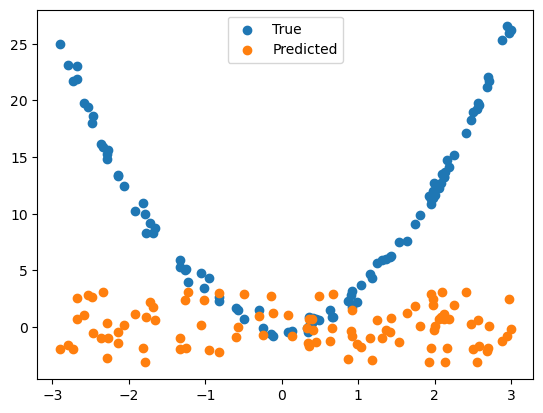

In [21]:
# Now train a linear regression function on the new data!
# pred_tr = rls_train(x, y, reg_par):
# trsf_x_tr = transformed x_train
# Generated quadratic data already, x_tr and y_tr generated
	# then x_tr transformed into trsf_w_rls
reg_par = 0.01
trsf_w_rls = rls_train(trsf_x_tr, y_tr, 0.01)
print("trsf_w_rls: {0}".format(trsf_w_rls))

trsf_pred_tr = rls_predict(trsf_x_tr, trsf_w_rls)
print("pred_tr: {0}".format(trsf_pred_tr))

# Create a subplot
fig, ax = plt.subplots()

# Plot the true values
ax.scatter(x_tr, y_tr, label="True")

# Plot the predicted values
ax.scatter(x_tr, pred_tr, label="Predicted")

# Add a legend to the plot
ax.legend(loc="best")

# Appending new column, added more precision to the chart from single variable equation to Polynomial equation which is more appropriate to this question

# Part 2: Kernel Least Squares

## Implement 3 types of kernel

The `kernel_matrix` function takes as input two arrays of data, and outputs the kernel matrix evaluated at every pair of points.

You should implement it using the formulas seen in class for the following kernels:
 - linear kernel -- here the `param` argument can be ignored
 - polynomial kernel -- here the `param` argument is the exponent of the kernel
 - gaussian kernel -- here the `param` argument is the kernel length-scale ($\sigma$)

In [22]:
def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
			ماتریس فاصله‌های مجذور زوجی بین تمام نقاط X1 و X2 را محاسبه کنید.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

In [23]:
# A kernel is a function that quantifies the similarity or dissimilarity
	# between pairs of data points.
def kernel_matrix(X1, X2, kernel_type, param):
    """
    Compute the kernel matrix between two sets of data points.

    Parameters:
    - X1: array of shape n x d (first set of data points)
    - X2: array of shape m x d (second set of data points)
    - kernel_type: string, type of kernel to be used ('linear', 'polynomial', 'gaussian')
    - param: kernel parameter (exponent for polynomial, lengthscale for gaussian)

    Returns:
    - K: array of shape n x m, the computed kernel matrix
    """

    n, d1 = X1.shape
    m, d2 = X2.shape

    # Ensure the number of features (columns) in both sets id2, "Number of featuress the same
		# d1 == d2 is the condition, if the condition is true, executation will contiune
			# if the condition is false, error message will be depicted
    assert d1 == d2, "Number of features in X1 and X2 must be the same"

    # Initialize the kernel matrix K
		# Set a matrix with n rows and m columns to zeros 
    K = np.zeros((n, m))

    # Compute the kernel matrix based on the specified kernel type
    if kernel_type == 'linear':
        # Linear Kernel: K(X1, X2) = X1 @ X2.T
				# @ means multiplication, here is dot production (between X1, X2 Transpose)
        K = X1 @ X2.T
    elif kernel_type == 'polynomial':
        # Polynomial Kernel: K(X1, X2) = (X1 @ X2.T + 1)^exponent
        exponent = param # taken as an input
				# dot production between X1 and X2 transpose + 1
        K = (X1 @ X2.T + 1) ** exponent
    elif kernel_type == 'gaussian':
        # Gaussian (RBF) Kernel: K(X1, X2) = exp(-||X1 - X2||^2 / (2 * lengthscale^2))
        lengthscale = param
				# - X1: array of shape n x d (first set of data points)
		    # - X2: array of shape m x d (second set of data points)
				# \|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2
				# n rows
        for i in range(n):
						# m columns
            for j in range(m):
								# norm is differnece between two vectors
                K[i, j] = np.exp(-np.linalg.norm(X1[i] - X2[j]) ** 2 / (2 * lengthscale ** 2))
    else:
        # Raise an error for an unsupported kernel type
        raise ValueError("Unsupported kernel type: {}".format(kernel_type))

    return K

**Task:** Visualize the kernel (e.g. of the Gaussian type) for random data with different length-scales. What can you observe?

Text(0.5, 1.0, 'Gaussian kernel with sigma=1.000000')

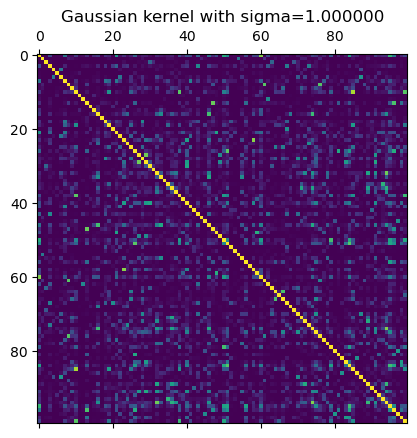

In [24]:
# Generates 100 rows samples(the number of rows) with 5 columns
D = np.random.randn(100, 5)
lengthscale = ...  # Set lengthscale to an appropriate value
lengthscale = 1
# lengthscale = 0.1

# Compute the Gaussian kernel matrix
K = kernel_matrix(D, D, "gaussian", lengthscale)

# Create a figure and axes for visualization
fig, ax = plt.subplots()

# Display the Gaussian kernel matrix as an image
ax.matshow(K)

# Set the title of the plot
ax.set_title("Gaussian kernel with sigma=%f" % (lengthscale))

In [ ]:
# Generates 100 rows samples(the number of rows) with 5 columns
D = np.random.randn(100, 5)
lengthscale = ...  # Set lengthscale to an appropriate value
# lengthscale = 1
lengthscale = 0.1

# Compute the Gaussian kernel matrix
K = kernel_matrix(D, D, "gaussian", lengthscale)

# Create a figure and axes for visualization
fig, ax = plt.subplots()

# Display the Gaussian kernel matrix as an image
ax.matshow(K)

# Set the title of the plot
ax.set_title("Gaussian kernel with sigma=%f" % (lengthscale))

In [ ]:
# Generates 100 rows samples(the number of rows) with 5 columns
D = np.random.randn(100, 5)
lengthscale = ...  # Set lengthscale to an appropriate value
# lengthscale = 1
lengthscale = 100

# Compute the Gaussian kernel matrix
K = kernel_matrix(D, D, "gaussian", lengthscale)

# Create a figure and axes for visualization
fig, ax = plt.subplots()

# Display the Gaussian kernel matrix as an image
ax.matshow(K)

# Set the title of the plot
ax.set_title("Gaussian kernel with sigma=%f" % (lengthscale))

## Implement Kernel RLS

Remember that, given kernel $K = k(x_i, x_j)$ for $i=(1, \dots, n)$ and $j=(1, \dots, n)$, KRLS learns a weight-vector with the following formula

$$(K + n \lambda I)w = Y$$

and then predictions on some new point $\tilde{x}$ are given by

$$f^{\mathrm{KRLS}}(\tilde{x}) = k(\tilde{x}, X^{\mathrm{train}}) w$$

In [ ]:
def krls_train(x, y, reg_par, kernel_type, kernel_par):
    """
    Train a kernelized regularized least squares (KRLS) model.

    Parameters:
    - x: array of shape n x d (training data)
    - y: array of shape n (training labels)
    - reg_par: regularization parameter or lambda
    - kernel_type: string, type of kernel to be used ('linear', 'polynomial', 'gaussian')
    - kernel_par: kernel parameter (exponent for polynomial, lengthscale for gaussian)

    Returns:
    - w: array of shape n, the learned weights
    """
    # Compute the kernel matrix
    K = kernel_matrix(x, x, kernel_type, kernel_par)
		
    # Solve the KRLS system of equations
    # w = (K + n * reg_par * I)^(-1) @ y
    n = len(y)
    I = np.eye(n)
    '''
		>>> I = np.eye(10)
		>>> I
			array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
			     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
			     [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
			     [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
			     [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
			     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
			     [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
			     [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
			     [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
			     [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
		'''

    w = np.linalg.solve(K + n * reg_par * I, y)

    return w

In [ ]:
def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par):
    """
    Make predictions using a trained kernelized regularized least squares (KRLS) model.

    Parameters:
    - x_ts: array of shape m x d (test data)
    - x_tr: array of shape n x d (training data used during training)
    - w: array of shape n, the learned weights
    - kernel_type: string, type of kernel to be used ('linear', 'polynomial', 'gaussian')
    - kernel_par: kernel parameter (exponent for polynomial, lengthscale for gaussian)

    Returns:
    - predictions: array of shape m, the predicted labels
    """
    # Compute the kernel matrix between test and training data
    K_ts_tr = kernel_matrix(x_ts, x_tr, kernel_type, kernel_par)

    # Make predictions
    # predictions = K_ts_tr @ w
    predictions = K_ts_tr @ w

    return predictions

**Implementation**

In [ ]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 2.0)

# Train a KRLS model with a Gaussian kernel
reg_par = 0.1  # Regularization parameter
kernel_type = 'gaussian'
kernel_par = 1.0  # Gaussian lengthscale parameter

# Train KRLS model
w_krls = krls_train(x_tr, y_tr, reg_par, kernel_type, kernel_par)

# Generate test data
x_ts, y_ts = quadratic_data_gen(50, np.array([3]), 2.0)

# Predict using the trained KRLS model
predictions_krls = krls_predict(x_ts, x_tr, w_krls, kernel_type, kernel_par)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot true data
ax.scatter(x_tr, y_tr, label='True (Training)', color='blue')
ax.scatter(x_ts, y_ts, label='True (Test)', color='green')

# Plot KRLS predictions
ax.scatter(x_ts, predictions_krls, label='KRLS Predictions', color='red', marker='x')

ax.legend()
ax.set_title('KRLS Predictions with Gaussian Kernel')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

**3.3. Generating a more complex non-linear dataset**

In [ ]:
def nonlinear_data_gen(n, d, low_d, high_d, sigma_noise):
    X = np.random.uniform(low=low_d, high=high_d, size=(n, d))
    assert X.shape == (n, d), "Shape of X incorrect"

    # Generate Y with a polynomial dependence
    w_true = np.random.randn(d, 1)
    Y = np.dot(X, w_true) ** 2  # Example of polynomial dependence (quadratic)

    assert Y.shape == (n, 1), "Shape of Y incorrect"

    # Add noise
    noise = np.random.normal(0, sigma_noise, size=(n, 1))
    Y_noisy = Y + noise

    return X, Y_noisy

In [ ]:
n_samples = 100
n_features = 2
lower_bound = -1
upper_bound = 1
noise_std_dev = 0.1

X, Y_noisy = nonlinear_data_gen(n_samples, n_features, lower_bound, upper_bound, noise_std_dev)

In [ ]:
X

In [ ]:
Y_noisy

**3.4. KRLS and cross-validation**

In [ ]:
def krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par):
    """
    Compute the k-fold cross-validation error for one KRLS model 
			(with speficied regularization, kernel and kernel parameter).
    
    This function returns both the training errors and the validation
			errors obtained from CV (as numpy arrays).
    """
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")
		
    # The number of the rows = n_tot
    n_tot = x_tr.shape[0]
    # The number of groups or folds
    # if n = 200 and num_folds = 5 => 200/5 = 40 -> 5 groups and each
        # group contains 40 members
    n_val = int(n_tot // num_folds)
    
    tr_errs, val_errs = [], []
    # `split_idx`: a list of arrays, each containing the validation
			# indices for 1 fold
		# random index generations -> for n=200 means 200 indexies in range 
			# [0,200]. 
		# Actually, a new 2D array is created in random indexies (displacement جابه جایی)
			# the array is rand_idx then it is spilited into various groups 
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
		# For each fold or group
    for fold in range(num_folds):
        # Set the indices in boolean mask for all validation samples
            # to `True`
        # Create an array with n_tot rows and 1 column in boolean format
        val_mask = np.zeros(n_tot, dtype=bool)
        ''' >>> val_mask = np.zeros(10, dtype=bool)
                >>> val_mask
                array([False, False, False, False, False, False, False, False, False, False])
        '''
        # All the elements in each group would be true
            # for fold=0 means group number 1, the indxies of group 1 in split_idx
                # would be true 
        val_mask[split_idx[fold]] = True
        
        # Now all other elements of the array which aren't true (false)
            # would be in kf_x_train and the true ones will be in kf_x_val
                # generally the number of elements for traning is more than test
        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]
        
        # Weight Calculation on training samples
        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par, kernel_type=kernel_type, kernel_par=kernel_par)
        
        # Based on the calculated weight, predication should be obtained.
        # def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par)
        # return predictions = K_ts_tr @ w
        pred_tr = krls_predict(kf_x_tr, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)

        # Error Calculation =  (Ypred-Ytrue)**2
        tr_errs.append(calc_err(pred_tr, kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))
		
		# asarray turns into an 2d array
    return np.asarray(tr_errs), np.asarray(val_errs)

In [ ]:
def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_type, kernel_par_list):
    """Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    # Initialize a matrix to store errors for each combination of regularization and kernel parameters
				# len(reg_par_list) = regularization and len(kernel_par_list)) = kernel parameters
		# Filled by zeros 
    errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    
    # Loop over regularization parameters as row of the matrix
		# enumerate [10,2,31,26,5] => ([0,10],[1,2],[2,31],[3,26],[4,5])
    for i, reg_par in enumerate(reg_par_list):
        # Loop over kernel parameters as column of the matrix
        for j, kernel_par in enumerate(kernel_par_list):
            # Calculate training and validation errors using K-Fold Cross-Validation
            tr_error, val_error = krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par)
            
            # Calculate the mean validation error and store it in the errors matrix
            errors[i][j] = np.mean(val_error)
    
    # Find the indices of the minimum error in the errors matrix
    '''
    >>> y = np.array([[2,3], [4,5]])
    >>> y.flatten()
            array([2, 3, 4, 5])
    
    >>> # Original shape
    >>> shape_1d = (3,)
    >>> Flat index
    >>> flat_index = 4
    >>> # Unravel the index
    >>> indices_1d = np.unravel_index(flat_index, shape_1d)
    >>> print(indices_1d)
    
    # Mine
    # Original 1D array
    # index = 3
    [0, 1, 2, 3, 4, 5]
    
    # Convert to 2D array
    [#col0 1 2
        [0, 1,,2], # row 0
        [3, 4, 5]  # row 1
    ]
    
    # 3 is in the row 1 and column 0
    (3,)
    '''
    # (np.argmin(error), errors.shape)[0])
    	# Explore the index with the minimum value 
    # After exploring, then unraveled from 1D to 2D array like a mentioned example, and fetching from reg_par_list
    best_reg_par = reg_par_list[np.unravel_index(np.argmin(errors), errors.shape)[0]]
    best_kernel_par = kernel_par_list[np.unravel_index(np.argmin(errors), errors.shape)[1]]
    best_err = np.min(errors)
    
    # Print the best parameters and the corresponding error
    print(f"The best error (MSE={best_err*100:.2f}%) was obtained with "
          f"lambda={best_reg_par}, kernel-parameter={best_kernel_par}")
    
    # Return the best parameters and the corresponding error
    return best_reg_par, best_kernel_par, best_err